## Predicting Price with Size
In this project, we are working for a client who wants to create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400,000

In [262]:
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import plotly.graph_objects as go
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

### Import and wrangle data using function


In [263]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    #subset to properties in "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    #subset to apartment
    mask_apt = df["property_type"] == "apartment"
    #subset property price less than 400000
    mask_price = df["price_aprox_usd"] < 400000

    df = df[mask_ba & mask_apt & mask_price]

    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns = {"lat-lon"}, inplace=True)
    
    #split neighoburhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3] 
    df.drop(columns= {"place_with_parent_names"}, inplace=True)

    return df

In [264]:
df = wrangle("task2/buenos-aires-real-estate-1.txt")
print("df shape:", df.shape)
df.head()

df shape: (1343, 17)


,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [265]:
assert(len(df) <= 8606), f"df should have no more than 8606 observations, not {len(df)}"

In [266]:
#mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")

#mask_apt = df["property_type"] == "apartment"

#mask_price = df["price_aprox_usd"] < 400000

In [267]:
assert(len(df) <= 1781), f"df should have no more than 1781 observations, not {len(df)}."

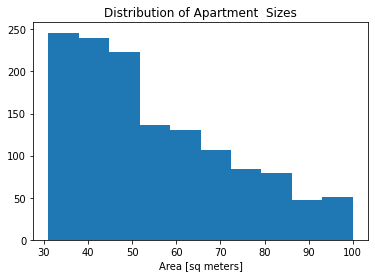

In [268]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment  Sizes");

In [269]:
df["surface_covered_in_m2"].describe()

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

In [270]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)

In [271]:
assert len(df) <= 1343

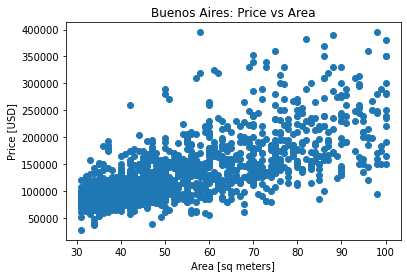

In [272]:
plt.scatter(
    x=df["surface_covered_in_m2"],
    y=df["price_aprox_usd"]
)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs Area");

In [273]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

In [274]:
assert X_train.shape == (1343, 1)
f"The shape of X_train should be (1343,1 ), not {X_train.shape}."

'The shape of X_train should be (1343,1 ), not (1343, 1).'

In [275]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)

In [276]:
assert y_train.shape == (1343,)

In [277]:
y_mean = y_train.mean()
y_mean

135527.83871928515

In [278]:
y_pred_baseline = [y_mean]*len(y_train)
len(y_pred_baseline) == len(y_train)

True

In [279]:
X_train["surface_covered_in_m2"]

4       70.0
9       42.0
29      54.0
40      42.0
41      50.0
        ... 
8589    42.0
8590    41.0
8593    43.0
8601    70.0
8604    52.0
Name: surface_covered_in_m2, Length: 1343, dtype: float64

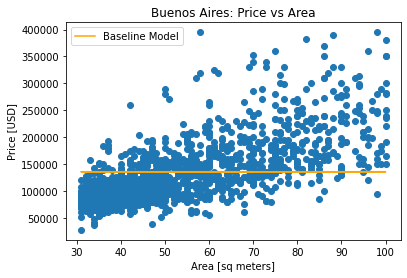

In [280]:
plt.plot(X_train.values, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs Area");
plt.legend();

In [281]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE 45199.46


In [282]:
model = LinearRegression()

In [283]:
assert isinstance(model, LinearRegression)

In [284]:
model.fit(X_train, y_train)

LinearRegression()

In [285]:
check_is_fitted(model)

In [286]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [287]:
assert(
    len(y_pred_training) == 1343
), f"There should be 1343 predictions in y_pred_training, not {len(y_pred_training)}"

In [288]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE", round(mae_training, 2))

Training MAE 31248.26


In [289]:
X_test = pd.read_csv("task2/buenos-aires-test-features.txt")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

In [290]:
intercept = round(model.intercept_)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433


In [291]:
coefficient = round(model.coef_[0])
print("Model coefficient for 'surface:_covered_in_m2':", coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for 'surface:_covered_in_m2': 2253


In [292]:
print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = 11433 + 2253 * surface_covered


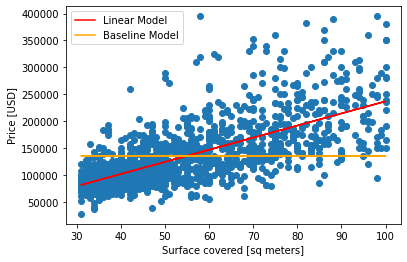

In [293]:
plt.plot(X_train.values, model.predict(X_train), color="r", label="Linear Model")
plt.plot(X_train.values, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Surface covered [sq meters]")
plt.ylabel("Price [USD]")
plt.legend();

<font size="+3"><strong>Predicting Price with Location</strong></font>

In [294]:
frame1 = wrangle("task2/buenos-aires-real-estate-1.txt")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   price                       1343 non-null   float64
 3   currency                    1343 non-null   object 
 4   price_aprox_local_currency  1343 non-null   float64
 5   price_aprox_usd             1343 non-null   float64
 6   surface_total_in_m2         965 non-null    float64
 7   surface_covered_in_m2       1343 non-null   float64
 8   price_usd_per_m2            927 non-null    float64
 9   price_per_m2                1343 non-null   float64
 10  floor                       379 non-null    float64
 11  rooms                       1078 non-null   float64
 12  expenses                    349 non-null    object 
 13  properati_url               1343 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [295]:
assert(
    frame1.shape[0] == 1343
)
f"frame1 should have 1343 rows, not {frame1.shape[0]}."
assert frame1.shape[1] == 17, f" frame1 should have 17 columns, not {frame1.shape[1]}"

In [296]:
frame2 =wrangle("task2/buenos-aires-real-estate-2.txt")
assert(
    frame2.shape[0] == 1315
), f"frame1 should have 1315 rows not {frame2.shape[0]}."
assert frame2.shape[1] == 17, f"frame1 should have 17 columns, not {frame2.shape[1]}."

In [297]:
df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   price                       2658 non-null   float64
 3   currency                    2658 non-null   object 
 4   price_aprox_local_currency  2658 non-null   float64
 5   price_aprox_usd             2658 non-null   float64
 6   surface_total_in_m2         1898 non-null   float64
 7   surface_covered_in_m2       2658 non-null   float64
 8   price_usd_per_m2            1818 non-null   float64
 9   price_per_m2                2658 non-null   float64
 10  floor                       769 non-null    float64
 11  rooms                       2137 non-null   float64
 12  expenses                    688 non-null    object 
 13  properati_url               2658 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [298]:
assert df.shape == (2658, 17), f"df is the wrong size: {df.shape}"

In [299]:
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"]
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [300]:
fig = px.scatter_3d(
    df, x="lon",y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd":"price"},
    width=600, height=500,
)

fig.update_traces(
    marker={"size": 4, "line": {"width":2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()

In [301]:
features = ["lon", "lat"]
X_train = df[features]
X_train.shape

(2658, 2)

# Build Model
## Baseline

In [302]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(2658,)

In [303]:
y_mean = y_train.mean()

In [304]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562]

In [305]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt Price", round(y_mean, 2))
print("Baseline MAE", round(mae_baseline, 2))

Mean apt Price 134732.97
Baseline MAE 45422.75


In [306]:
imputer = SimpleImputer()

In [307]:
assert isinstance(imputer, SimpleImputer)

In [308]:
imputer.fit(X_train)

SimpleImputer()

In [309]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     2658 non-null   float64
 1   lat     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


In [310]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [311]:
assert isinstance(model, Pipeline), "Did you instantiate your model?"

In [312]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [313]:
check_is_fitted(model["linearregression"])

In [314]:
y_pred_training = model.predict(X_train)

In [315]:
assert y_pred_training.shape == (2658,)

In [316]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE", round(mae_training, 2))


Training MAE 42962.72


In [317]:
X_test = pd.read_csv("task2/buenos-aires-test-features.txt")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    136372.324695
1    168620.352353
2    130231.628267
3    102497.549527
4    123482.077850
dtype: float64

In [318]:
intercept = model.named_steps["linearregression"].intercept_.round(0)
coefficients = model.named_steps["linearregression"].coef_.round(0)

In [319]:
print(
    f"Price = {intercept} + ({coefficients[0]} * longititude) + ({coefficients[1]} * latitude)"
)

Price = 38113587.0 + (196709.0 * longititude) + (765467.0 * latitude)


In [320]:
fig = px.scatter_3d(
    df, x="lon", y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600, height=400,
)

x_plane = np.linspace(df['lon'].min(), df["lon"].max(), 10)
y_plane = np.linspace(df['lat'].min(), df["lat"].max(), 10)
xx, yy =  np.meshgrid(x_plane, y_plane)

z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.meshgrid(z_plane, (10,1))

fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

fig.update_traces(
    marker={"size": 4, "line": {"width":2, "color":"DarkSlateGrey"}},
    selector={"mode": "markers"}
)
fig.show()

<font size="+3"><strong>2.3. Predicting Price with Neighborhood</strong></font>

In [321]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [322]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    #split neighoburhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3] 
    df.drop(columns= { "place_with_parent_names" }, inplace=True)
    
    return df

In [323]:
files = glob("task2/buenos-aires-real-estate-*.txt")
files

['task2\\buenos-aires-real-estate-1.txt',
 'task2\\buenos-aires-real-estate-2.txt',
 'task2\\buenos-aires-real-estate-3.txt',
 'task2\\buenos-aires-real-estate-4.txt',
 'task2\\buenos-aires-real-estate-5.txt']

In [324]:
assert len(files) == 5, f" `files` should contain 5 items, not {len(files)} "

In [325]:
frames = []
for file in files:
    df = wrangle(filepath=file)
    frames.append(df)

In [326]:
assert len(frames) == 5, f" frames should contain 5 items, not {len(frames)}"
assert all( [isinstance(frame, pd.DataFrame) for frame in frames]), "The items in frames should all be dataframes"

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 3 to 8597
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1331 non-null   object 
 1   property_type               1331 non-null   object 
 2   price                       1331 non-null   float64
 3   currency                    1331 non-null   object 
 4   price_aprox_local_currency  1331 non-null   float64
 5   price_aprox_usd             1331 non-null   float64
 6   surface_total_in_m2         1002 non-null   float64
 7   surface_covered_in_m2       1331 non-null   float64
 8   price_usd_per_m2            956 non-null    float64
 9   price_per_m2                1331 non-null   float64
 10  floor                       378 non-null    float64
 11  rooms                       1053 non-null   float64
 12  expenses                    353 non-null    float64
 13  properati_url               1331 

In [328]:
df =pd.concat(frames, ignore_index=True)

In [329]:
assert len(df) == 6582, f" df is the wrong size: {len(df)}."

In [330]:
assert df.shape == (6582, 17), f" df is the wring size: {df.shape}."
assert ("place_with_parent_names" not in df), 'Remember to remove the "place_with_parent_names" column.'

In [331]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [332]:
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [333]:
assert X_train.shape == (6582, 1), f" X_train is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f" y_train is the wring size: {y_train.shape}."

In [334]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price 132383.83701458524
Baseline MAE: 44860.10834274133


In [335]:
X_train.head()
model = LinearRegression

In [336]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [337]:
assert XT_train.shape == (6582, 57), f"XT_train is the rong shape {XT_train.shape}"

In [338]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [339]:
model =  make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [340]:
check_is_fitted(model[-1])

In [341]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


Let's check our test performance

Run the code below to import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a Series of predictions using your model.

In [342]:
X_test = pd.read_csv("task2/buenos-aires-test-features.txt")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

### Communicate Result

In [343]:
"""
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("Coefficient len:", len(coefficients))
print(coefficients[:5])
"""


'\nintercept = model.named_steps["linearregression"].intercept_\ncoefficients = model.named_steps["linearregression"].coef_\nprint("Coefficient len:", len(coefficients))\nprint(coefficients[:5])\n'

In [344]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("Coefficient len:", len(coefficients))
print(coefficients[:5])

Coefficient len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [345]:
assert isinstance(intercept, float),f"intercept should be a float, not {type(intercept)}"
assert isinstance(coefficients, np.ndarray), f"coeficients should be afloat, not {type(coefficients)}"
assert coefficients.shape == (57,), f" coefficient is wrong shape {coefficients.shape}."

In [346]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])

features len: 57
['neighborhood_Chacarita', 'neighborhood_Villa Luro', 'neighborhood_Caballito', 'neighborhood_Constitución', 'neighborhood_Once']


In [347]:
assert isinstance(feature_names, list), f"features should be a list, not {type(features)}"
assert len(feature_names) == len(coefficients), f"You should have thesame number of features and coefficients."

In [348]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [349]:
assert isinstance(feat_imp, pd.Series), f"feat_imp should be a float, not {type(feat_imp)}."
assert feat_imp.shape == (57,), f"feat_imp is wrong shape: {feat_imp.shape}"
assert all( a== b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))), "The index of feat_imp should be identical to features."


In [350]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f" + ({round(c,2)} * {f})")

price = 118524.65
 + (-2898.96 * neighborhood_Chacarita)
 + (-6.3 * neighborhood_Villa Luro)
 + (9252.89 * neighborhood_Caballito)
 + (-41748.73 * neighborhood_Constitución)
 + (-3230.37 * neighborhood_Once)
 + (2903.34 * neighborhood_Almagro)
 + (45934.41 * neighborhood_Palermo)
 + (-8662.28 * neighborhood_Flores)
 + (46954.21 * neighborhood_Belgrano)
 + (-13729.1 * neighborhood_Liniers)
 + (6277.05 * neighborhood_Villa Crespo)
 + (-10678.63 * neighborhood_San Cristobal)
 + (-7974.66 * neighborhood_Congreso)
 + (14701.16 * neighborhood_Saavedra)
 + (-11172.55 * neighborhood_Balvanera)
 + (-29585.61 * neighborhood_Parque Avellaneda)
 + (72740.78 * neighborhood_Recoleta)
 + (5638.47 * neighborhood_San Telmo)
 + (42831.32 * neighborhood_Nuñez)
 + (55590.93 * neighborhood_Barrio Norte)
 + (-6323.68 * neighborhood_Parque Centenario)
 + (4330.55 * neighborhood_Abasto)
 + (-7905.29 * neighborhood_Centro / Microcentro)
 + (-19370.74 * neighborhood_)
 + (-7108.23 * neighborhood_Paternal)
 + (-

In [351]:
assert isinstance(model[-1], Ridge), "Did you retrain your model using a Ridge predictor?"

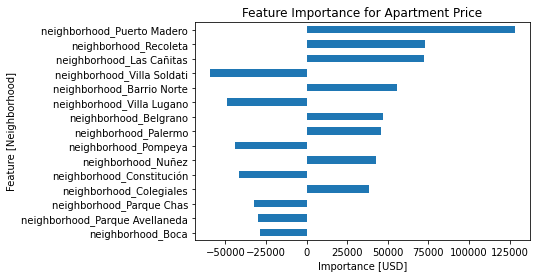

In [352]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature [Neighborhood]")
plt.title("Feature Importance for Apartment Price");